In [1]:
import logging
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import textwrap

In [2]:
# Try to install caas_jupyter_tools if available, else fallback to None

try:
    import caas_jupyter_tools
    from caas_jupyter_tools import display_dataframe_to_user
except ImportError:
    display_dataframe_to_user = None

In [3]:
RANDOM_SEED = 42
DATA_PATH = Path("../data/raw/synthetic_coffee_health_10000.csv")  # <= set to your CSV filename
OUTPUT_DIR = Path("../outputs/reports")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
log = logging.getLogger("data_understanding")
np.random.seed(RANDOM_SEED)

In [5]:
def safe_load_csv(path: Path) -> pd.DataFrame:
    """Load CSV safely; raise helpful message if not found."""
    log.info(f"Loading data from: {path.resolve()}")
    if not path.exists():
        raise FileNotFoundError(f"Data file not found at: {path.resolve()}")
    df = pd.read_csv(path, low_memory=False)
    log.info(f"Loaded dataframe with shape {df.shape}")
    return df

In [6]:
def show_df(df: pd.DataFrame, title: str, n: int = 8):
    """Display DataFrame nicely if environment supports it, else print head."""
    if display_dataframe_to_user:
        display_dataframe_to_user(title, df.head(n))
    else:
        print(f"\n--- {title} (first {n} rows) ---")
        print(df.head(n))

In [7]:
def save_df(df: pd.DataFrame, filename: str):
    path = OUTPUT_DIR / filename
    df.to_csv(path, index=False)
    log.info(f"Saved: {path}")
    return path

In [8]:
df = safe_load_csv(DATA_PATH)

INFO: Loading data from: /home/Dhananjana/GitHub/coffee-minining/data/raw/synthetic_coffee_health_10000.csv
INFO: Loaded dataframe with shape (10000, 16)


In [9]:
print("\n=== BASIC OVERVIEW ===")
print("shape:", df.shape)
print("columns:", list(df.columns))
show_df(df, "Sample rows")


=== BASIC OVERVIEW ===
shape: (10000, 16)
columns: ['ID', 'Age', 'Gender', 'Country', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'Sleep_Quality', 'BMI', 'Heart_Rate', 'Stress_Level', 'Physical_Activity_Hours', 'Health_Issues', 'Occupation', 'Smoking', 'Alcohol_Consumption']

--- Sample rows (first 8 rows) ---
   ID  Age  Gender  Country  Coffee_Intake  Caffeine_mg  Sleep_Hours  \
0   1   40    Male  Germany            3.5        328.1          7.5   
1   2   33    Male  Germany            1.0         94.1          6.2   
2   3   42    Male   Brazil            5.3        503.7          5.9   
3   4   53    Male  Germany            2.6        249.2          7.3   
4   5   32  Female    Spain            3.1        298.0          5.3   
5   6   32    Male   Mexico            3.4        326.4          6.4   
6   7   53    Male   France            2.7        252.1          7.8   
7   8   44  Female   Canada            4.5        423.5          5.5   

  Sleep_Quality   BMI  Heart_Rate S

In [10]:
types = df.dtypes.astype(str)
non_null = df.count()
unique = df.nunique(dropna=True)
data_dict = pd.DataFrame({
    "column": df.columns,
    "dtype": [types[c] for c in df.columns],
    "non_null_count": [int(non_null[c]) for c in df.columns],
    "unique_count": [int(unique[c]) for c in df.columns]
})
print("\n=== DATA DICTIONARY (draft) ===")
if display_dataframe_to_user:
    display_dataframe_to_user("Data Dictionary (draft)", data_dict)
else:
    print(data_dict)
save_df(data_dict, "data_dictionary_draft.csv")

INFO: Saved: ../outputs/reports/data_dictionary_draft.csv



=== DATA DICTIONARY (draft) ===
                     column    dtype  non_null_count  unique_count
0                        ID    int64           10000         10000
1                       Age    int64           10000            59
2                    Gender   object           10000             3
3                   Country   object           10000            20
4             Coffee_Intake  float64           10000            78
5               Caffeine_mg  float64           10000          4277
6               Sleep_Hours  float64           10000            71
7             Sleep_Quality   object           10000             4
8                       BMI  float64           10000           220
9                Heart_Rate    int64           10000            58
10             Stress_Level   object           10000             3
11  Physical_Activity_Hours  float64           10000           151
12            Health_Issues   object            4059             3
13               Occupation  

PosixPath('../outputs/reports/data_dictionary_draft.csv')

In [11]:
print("\n=== MISSING VALUE REPORT ===")
missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df) * 100).round(3)
missing_report = pd.DataFrame({
    "column": df.columns,
    "missing_count": [int(missing_counts[c]) for c in df.columns],
    "missing_percent": [float(missing_pct[c]) for c in df.columns]
}).sort_values("missing_count", ascending=False)
if display_dataframe_to_user:
    display_dataframe_to_user("Missing Value Report", missing_report)
else:
    print(missing_report)
save_df(missing_report, "missing_report.csv")

INFO: Saved: ../outputs/reports/missing_report.csv



=== MISSING VALUE REPORT ===
                     column  missing_count  missing_percent
12            Health_Issues           5941            59.41
0                        ID              0             0.00
2                    Gender              0             0.00
1                       Age              0             0.00
4             Coffee_Intake              0             0.00
5               Caffeine_mg              0             0.00
6               Sleep_Hours              0             0.00
3                   Country              0             0.00
7             Sleep_Quality              0             0.00
8                       BMI              0             0.00
10             Stress_Level              0             0.00
9                Heart_Rate              0             0.00
11  Physical_Activity_Hours              0             0.00
13               Occupation              0             0.00
14                  Smoking              0             0.00
15      Al

PosixPath('../outputs/reports/missing_report.csv')

In [12]:
print("\n=== DUPLICATES ===")
dup_count = int(df.duplicated().sum())
print("duplicate rows:", dup_count)
if dup_count > 0:
    dup_sample = df[df.duplicated(keep=False)].head(5)
    if display_dataframe_to_user:
        display_dataframe_to_user("Duplicate row sample", dup_sample)
    else:
        print(dup_sample)


=== DUPLICATES ===
duplicate rows: 0


In [13]:
print("\n=== TARGET DETECTION ===")
target_candidates = [c for c in df.columns if ("health" in c.lower() or "status" in c.lower() or "issue" in c.lower() or "label" in c.lower())]
if not target_candidates:
    print("No obvious target column detected. Please set target manually.")
    target_col = None
else:
    target_col = target_candidates[0]
    print("Detected candidate target column:", target_col)
    vc = df[target_col].value_counts(dropna=False)
    vc_df = vc.rename_axis(target_col).reset_index(name="count")
    vc_df["percent"] = (vc_df["count"] / vc_df["count"].sum() * 100).round(3)
    if display_dataframe_to_user:
        display_dataframe_to_user("Target distribution", vc_df)
    else:
        print(vc_df)


=== TARGET DETECTION ===
Detected candidate target column: Health_Issues
  Health_Issues  count  percent
0           NaN   5941    59.41
1          Mild   3579    35.79
2      Moderate    463     4.63
3        Severe     17     0.17


In [14]:
print("\n=== NUMERIC SUMMARY ===")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_summary = df[numeric_cols].describe().T
num_summary["missing_count"] = df[numeric_cols].isnull().sum().astype(int)
if display_dataframe_to_user:
    display_dataframe_to_user("Numeric summary", num_summary.reset_index().rename(columns={"index":"feature"}))
else:
    print(num_summary)
save_df(num_summary.reset_index().rename(columns={"index":"feature"}), "numeric_summary.csv")

INFO: Saved: ../outputs/reports/numeric_summary.csv



=== NUMERIC SUMMARY ===
                           count        mean          std   min      25%  \
ID                       10000.0  5000.50000  2886.895680   1.0  2500.75   
Age                      10000.0    34.94910    11.160939  18.0    26.00   
Coffee_Intake            10000.0     2.50923     1.450248   0.0     1.50   
Caffeine_mg              10000.0   238.41101   137.748815   0.0   138.75   
Sleep_Hours              10000.0     6.63622     1.222055   3.0     5.80   
BMI                      10000.0    23.98686     3.906411  15.0    21.30   
Heart_Rate               10000.0    70.61780     9.822951  50.0    64.00   
Physical_Activity_Hours  10000.0     7.48704     4.315180   0.0     3.70   
Smoking                  10000.0     0.20040     0.400320   0.0     0.00   
Alcohol_Consumption      10000.0     0.30070     0.458585   0.0     0.00   

                            50%       75%      max  missing_count  
ID                       5000.5  7500.250  10000.0              0  
Ag

PosixPath('../outputs/reports/numeric_summary.csv')

In [15]:
print("\n=== CATEGORICAL OVERVIEW ===")
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
low_card_num = [c for c in numeric_cols if df[c].nunique() <= 30]
cat_cols_extended = sorted(set(cat_cols + low_card_num))
cat_rows = []
for c in cat_cols_extended:
    sample_vals = df[c].dropna().unique().tolist()[:12]
    cat_rows.append({"column": c, "unique_count": int(df[c].nunique(dropna=True)), "sample_values": ", ".join(map(str, sample_vals))})
cat_df = pd.DataFrame(cat_rows).sort_values("unique_count", ascending=False)
if display_dataframe_to_user:
    display_dataframe_to_user("Categorical overview", cat_df)
else:
    print(cat_df)
save_df(cat_df, "categorical_overview.csv")

INFO: Saved: ../outputs/reports/categorical_overview.csv



=== CATEGORICAL OVERVIEW ===
                column  unique_count  \
1              Country            20   
4           Occupation             5   
5        Sleep_Quality             4   
2               Gender             3   
7         Stress_Level             3   
3        Health_Issues             3   
0  Alcohol_Consumption             2   
6              Smoking             2   

                                       sample_values  
1  Germany, Brazil, Spain, Mexico, France, Canada...  
4        Other, Service, Office, Student, Healthcare  
5                        Good, Fair, Excellent, Poor  
2                                Male, Female, Other  
7                                  Low, Medium, High  
3                             Mild, Moderate, Severe  
0                                               0, 1  
6                                               0, 1  


PosixPath('../outputs/reports/categorical_overview.csv')


=== CORRELATION MATRIX (numeric) ===


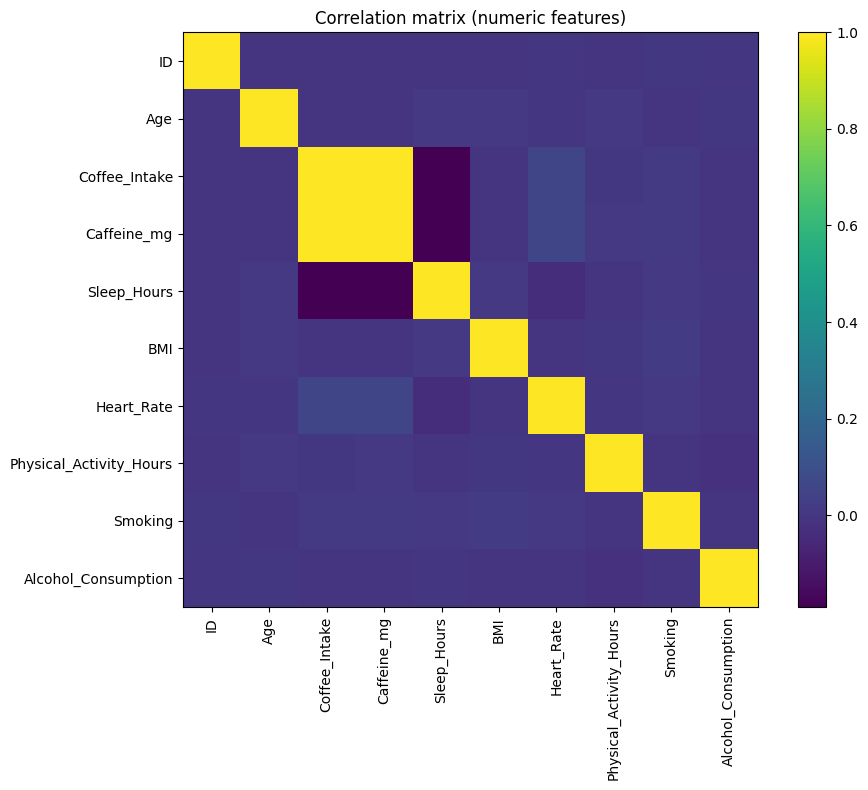

In [16]:
print("\n=== CORRELATION MATRIX (numeric) ===")
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(10, 8))
    plt.imshow(corr)  # no custom color map (best-practice for generic environments)
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title("Correlation matrix (numeric features)")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric features for correlation matrix.")


=== UNIVARIATE HISTOGRAMS (numeric; up to first 8 columns) ===


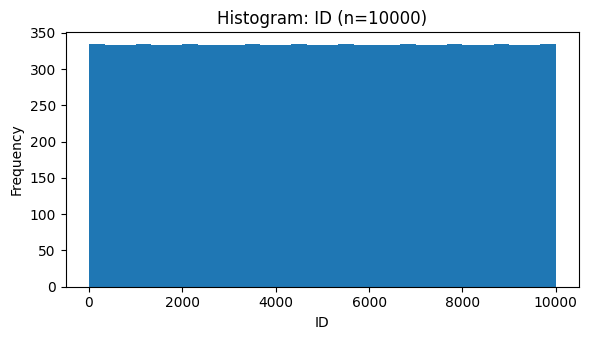

Saved plot to: ../outputs/reports/histogram_ID.png


<Figure size 640x480 with 0 Axes>

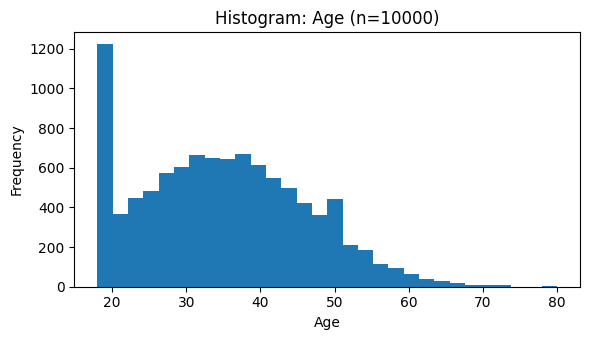

Saved plot to: ../outputs/reports/histogram_Age.png


<Figure size 640x480 with 0 Axes>

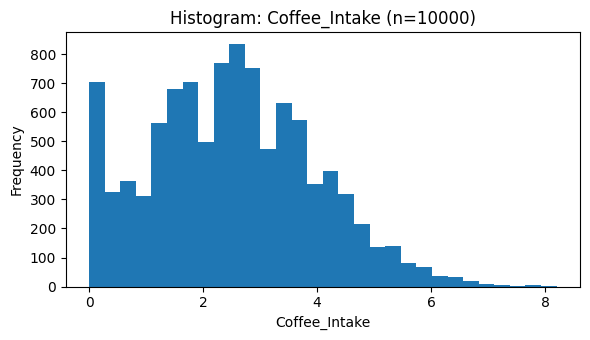

Saved plot to: ../outputs/reports/histogram_Coffee_Intake.png


<Figure size 640x480 with 0 Axes>

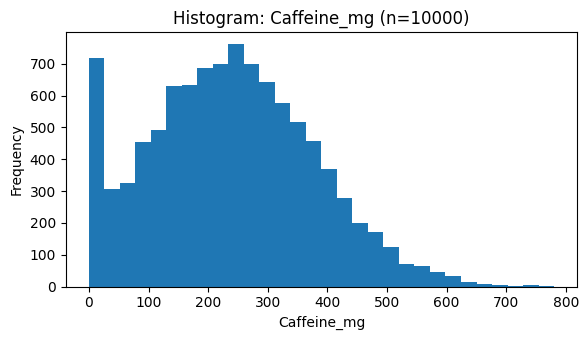

Saved plot to: ../outputs/reports/histogram_Caffeine_mg.png


<Figure size 640x480 with 0 Axes>

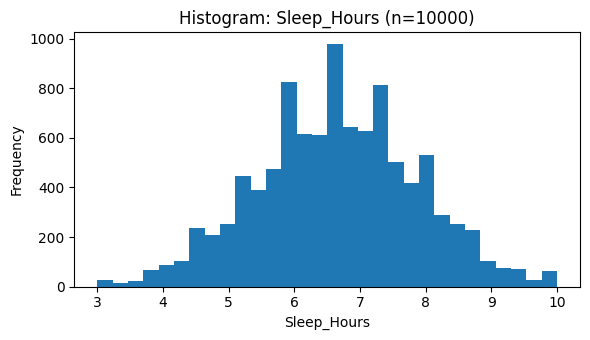

Saved plot to: ../outputs/reports/histogram_Sleep_Hours.png


<Figure size 640x480 with 0 Axes>

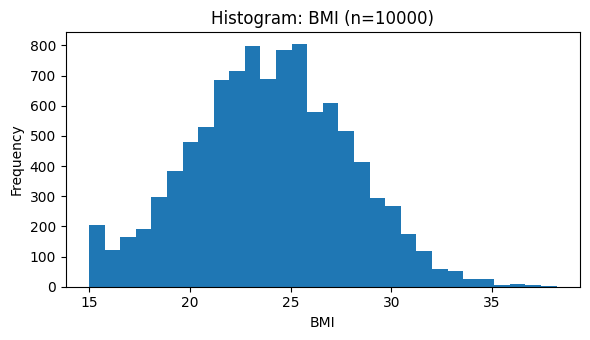

Saved plot to: ../outputs/reports/histogram_BMI.png


<Figure size 640x480 with 0 Axes>

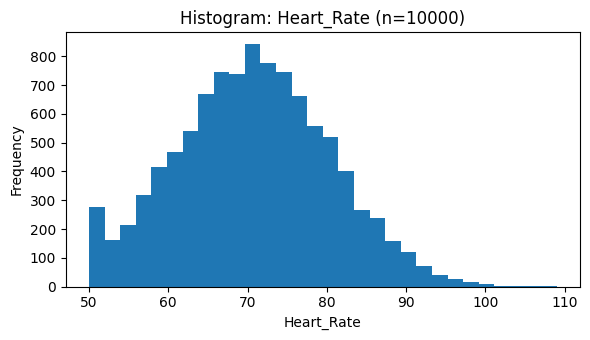

Saved plot to: ../outputs/reports/histogram_Heart_Rate.png


<Figure size 640x480 with 0 Axes>

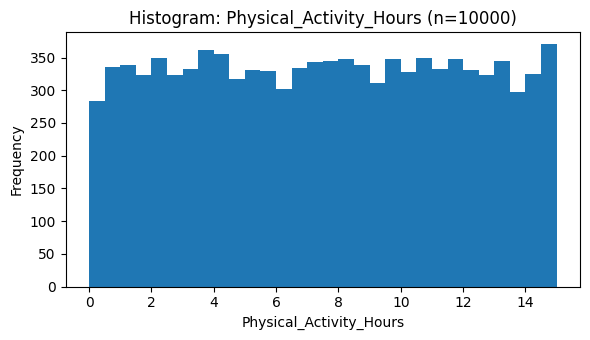

Saved plot to: ../outputs/reports/histogram_Physical_Activity_Hours.png


<Figure size 640x480 with 0 Axes>

In [17]:
print("\n=== UNIVARIATE HISTOGRAMS (numeric; up to first 8 columns) ===")
plot_cols = numeric_cols[:8]
for c in plot_cols:
    plt.figure(figsize=(6, 3.5))
    vals = df[c].dropna()
    plt.hist(vals, bins=30)
    plt.title(f"Histogram: {c} (n={len(vals)})")
    plt.xlabel(c)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    filename = f"histogram_{c}.png"
    save_path = os.path.join(OUTPUT_DIR, filename)
    plt.savefig(save_path)
    print(f"Saved plot to: {save_path}")

In [18]:
summary = {
    "shape": df.shape,
    "num_columns": int(df.shape[1]),
    "num_rows": int(df.shape[0]),
    "numeric_columns": numeric_cols,
    "categorical_columns": cat_cols_extended,
    "detected_target": target_col,
    "duplicate_count": dup_count,
    "missing_columns": missing_report[missing_report["missing_count"]>0]["column"].tolist()
}
with open(OUTPUT_DIR / "data_understanding_summary.json", "w") as f:
    json.dump(summary, f, indent=2)
log.info(f"Saved summary JSON to {OUTPUT_DIR/'data_understanding_summary.json'}")


INFO: Saved summary JSON to ../outputs/reports/data_understanding_summary.json


In [19]:
print("\n=== RECOMMENDED NEXT STEPS ===")
print(textwrap.dedent("""
1. Confirm the target column. If the heuristic picked the wrong column, set `target_col` explicitly.
2. Design imputation strategies per-column (mean/median for numeric, mode or 'missing' label for categorical).
3. Decide how to handle duplicates (drop vs merge after domain checks).
4. For categorical variables: choose encoding strategy (one-hot for low-cardinality, target/ordinal encoding for high-cardinality).
5. Plan scaling/normalization: StandardScaler or RobustScaler for numeric features before modeling.
6. If severe class imbalance exists, plan resampling or class-weighting strategies (SMOTE, undersampling, or class weights).
7. Start building a reproducible preprocessing Pipeline (sklearn Pipeline) so that preprocessing and modeling are deterministic.
"""))

print("\nOutputs written to folder:", OUTPUT_DIR.resolve())
print("Files created:", [p.name for p in OUTPUT_DIR.iterdir()])


=== RECOMMENDED NEXT STEPS ===

1. Confirm the target column. If the heuristic picked the wrong column, set `target_col` explicitly.
2. Design imputation strategies per-column (mean/median for numeric, mode or 'missing' label for categorical).
3. Decide how to handle duplicates (drop vs merge after domain checks).
4. For categorical variables: choose encoding strategy (one-hot for low-cardinality, target/ordinal encoding for high-cardinality).
5. Plan scaling/normalization: StandardScaler or RobustScaler for numeric features before modeling.
6. If severe class imbalance exists, plan resampling or class-weighting strategies (SMOTE, undersampling, or class weights).
7. Start building a reproducible preprocessing Pipeline (sklearn Pipeline) so that preprocessing and modeling are deterministic.


Outputs written to folder: /home/Dhananjana/GitHub/coffee-minining/outputs/reports
Files created: ['data_dictionary_draft.csv', 'missing_report.csv', 'numeric_summary.csv', 'categorical_overview.